<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [9]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install plot_metric

Note: you may need to restart the kernel to use updated packages.


In [11]:
import re
import os
import sys
import csv
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import string
import warnings
%matplotlib inline
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from plot_metric.functions import BinaryClassification
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')  # Download the POS tagger
nltk.download('wordnet')  # Download WordNet words and synonyms


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:

    
    
- у тебя тут есть лишние импорты, то что ты не использовано или использовано не верно - стоит убрать, чтобы поберечь ресурсы      

    
- есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html). Есть что поправить 



In [12]:
data_path = "/datasets/toxic_comments.csv"
data_raw = pd.read_csv(data_path)
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print('Number of duplicates:', data_raw.duplicated().sum())
print('Number of NA values:', data_raw.isna().sum())
print("\n")
print("**Sample data:**")
data_raw.head()

Number of rows in data = 159292
Number of columns in data = 3
Number of duplicates: 0
Number of NA values: Unnamed: 0    0
text          0
toxic         0
dtype: int64


**Sample data:**


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    


Unnamed: 0 это "след" старых индексов. Если ты уберёшь первые 10 примеров и своего датасета, сохранишь его, а потом откроешь,  то появится столбец Unnamed: 0 начиная с цифры 9, и появится новый индексы начиная с нуля 


Но это мелочь,  даже не нужно ничего исправлять. Просто знай, чтобы увидев такое в чужом коде не удивляться что бы это могло означать

<AxesSubplot:xlabel='toxic', ylabel='count'>

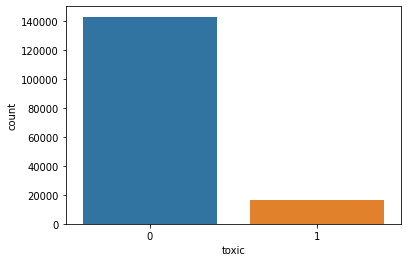

In [13]:
sns.countplot(x = 'toxic', data = data_raw)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. 


Плюс за

    

-  проверку на сбалансированность 




<div class="alert alert-warning">

Совет: 



    
- .sample() вместо .head(), ведь если данные каким то образом упорядоченны, то шансы увидеть что то разнообразное через .sample чуть выше чем через .head (или .tail)     
   







Код ниже работает на локальном компьютере, возвращая картинки с облаком слов в зависимости от класса твитов (токсичные или не токчичные или все)
Тут же я получаю ошибку "ValueError: Only supported for TrueType fonts"

Ошибка "Only supported for TrueType fonts" обычно возникает из-за проблем с настройками шрифтов в matplotlib или среде выполнения кода. Ваша ошибка может быть связана с matplotlib, который пытается использовать шрифт, который не поддерживается. Нужно как то правильно задать шрифты, загрузив их в правильное место
пробовал загружать в локальные папку TrueType шрифт # font_path = os.path.abspath('./LiberationSans-Regular.ttf')
Но все равно не помогает



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


    
Если погуглить, то есть такие варианты решения    
 
В тренажере облако импортируем так



    !/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  


И возможно дополнительно надо будет сделать



    !pip install --upgrade Pillow





 
    

In [14]:
# # Укажем шрифт, который поддерживается вашей средой выполнения кода
# # Например, шрифт 'Liberation Sans' поддерживается по умолчанию в большинстве сред
# font_path = os.path.abspath('./LiberationSans-Regular.ttf')

# df_toxic = data_raw[data_raw['toxic']==1]
# df_nottoxic = data_raw[data_raw['toxic']==0]

# All = " ".join(review for review in data_raw.text)
# toxic = " ".join(review for review in df_toxic.text)
# nottoxic = " ".join(review for review in df_nottoxic.text)

# fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# wordcloud_all = WordCloud(font_path=font_path,max_font_size=50, max_words=100, background_color="black").generate(All)
# wordcloud_toxic = WordCloud(font_path=font_path,max_font_size=50, max_words=100, background_color="black").generate(toxic)
# wordcloud_nottoxic = WordCloud(font_path=font_path,max_font_size=50, max_words=100, background_color="black").generate(nottoxic)


# ax[0].imshow(wordcloud_all, interpolation='bilinear')
# ax[0].set_title('All comments', fontsize=30)
# ax[0].axis('off')
# ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
# ax[1].set_title('Toxic comments',fontsize=30)
# ax[1].axis('off')
# ax[2].imshow(wordcloud_nottoxic, interpolation='bilinear')
# ax[2].set_title('NonToxic Comments',fontsize=30)
# ax[2].axis('off')


![Optional Text](./download.png)


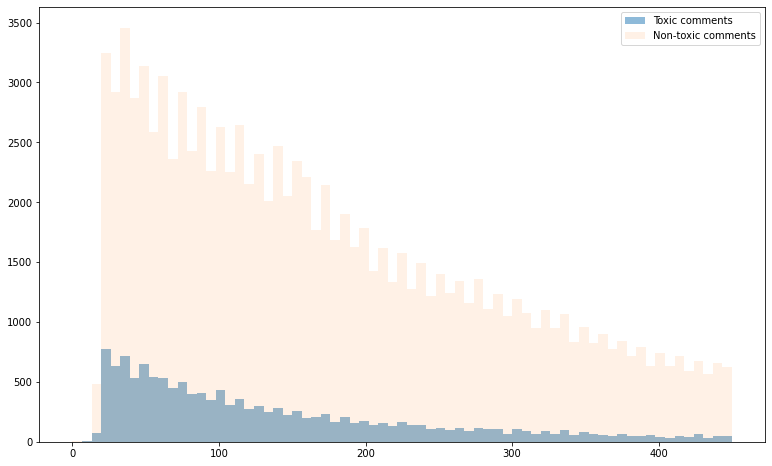

In [15]:
TOXIC_1 = data_raw[data_raw['toxic'] == 1]['text'].apply(lambda x: len(x) - len(' '))
TOXIC_0 = data_raw[data_raw['toxic'] == 0]['text'].apply(lambda x: len(x) - len(' '))
bins_ = np.linspace(0, 450, 70)
plt.figure(figsize=(13,8))
plt.hist(TOXIC_1, bins= bins_, alpha = 0.5, label = 'Toxic comments')
plt.hist(TOXIC_0, bins= bins_, alpha = 0.1, label = 'Non-toxic comments')
plt.legend()

Не токсичные комменты намного длиннее

Чтобы очистить текстовые данные, мы собираемся выполнить следующие шаги:

1. Лемматизация мы превращаем любую форму слова в его корневое слово с библиотекой SpaCy

In [17]:
data = data_raw

In [20]:
%%time

# Функция для лемматизации текста
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())

def lemmatize(text):
    global nlp
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Применим функцию к столбцу 'text' в нашем dataframe
data['clear_text'] = data['text'].apply(clear_text)

data['lemmatized_text'] = data['clear_text'].apply(lemmatize)


CPU times: user 35min 37s, sys: 2.97 s, total: 35min 40s
Wall time: 35min 41s


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



spacy отлично подходит




</div>


In [ ]:
# lemmatizer = WordNetLemmatizer()

# # Function to convert nltk POS tags to wordnet tags
# def nltk_to_wordnet_pos(nltk_pos):
#     if nltk_pos.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_pos.startswith('V'):
#         return wordnet.VERB
#     elif nltk_pos.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_pos.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

# def lemmatize_text(text):
#     # Tokenize the text
#     words = word_tokenize(text)
    
#     # POS tagging
#     pos_tags = pos_tag(words)
    
#     # Lemmatize with POS tag
#     lemmatized_words = [lemmatizer.lemmatize(word, nltk_to_wordnet_pos(pos)) for word, pos in pos_tags]
    
#     # Join the words back into a string
#     lemmatized_text = ' '.join(lemmatized_words)
    
#     return lemmatized_text


# # # Apply the function to the 'text' column of your dataframe
# # data['lemmatized'] = data['text'].apply(lemmatize_text)


In [21]:
data.to_csv("data_lemmatized.csv", index=False)

In [ ]:
# data_lemmatized =  pd.read_csv("./data_lemmatized.csv")

In [ ]:
# data_lemmatized.head()

In [22]:
data.head()

,Unnamed: 0,text,toxic,clear_text,lemmatized_text
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,explanation why the edits made under my username hardcore metallica fan were reverted they weren...,explanation why the edit make under my username hardcore metallica fan be revert they weren t va...
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,d aww he match this background colour I m seemingly stuck with thank talk january utc
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevan...,hey man I m really not try to edit war it s just that this guy be constantly remove relevant inf...
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,more i can t make any real suggestions on improvement i wondered if the section statistics shoul...,more I can t make any real suggestion on improvement I wonder if the section statistic should be...
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on,you sir be my hero any chance you remember what page that s on


при помощи spacy лемматизировал текст и сохранил в локальный файл data.to_csv("data_lemmatized.csv", index=False)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:




- Плюс за использование apply, неэффективные циклы нам ни к чему.


- Да, всегда лучше проверить что получилось  в итоге, так всегда будет возможность поправить ошибку

<div class="alert alert-warning">


Совет: 


    
- попробуй .progress_apply, делает что .apply, но еще и показывает на какой итерации находится процесс.  

Для некоторых версий, чтобы заработал .progress_apply предварительно нужно сделать:
    
    
    from tqdm.notebook import tqdm
    tqdm.pandas()
    

И cудя по всему импорты нужно засунуть внутрь функции

То же самое делает .swifter.apply  Предварительно


    !pip install swifter
    import swifter


Если  процесс лемматизации затягивается, можно попробовать [.parallel_apply](https://pypi.org/project/pandarallel/),  кому-то это помогает уменьшить время прогона кода раз в 5-7. А у большинства он вообще не запускается ) Предварительно: 


    
    from pandarallel import pandarallel   
    tqdm.pandas(desc="progress")
    pandarallel.initialize(progress_bar = True)




 
- когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить ))  


 
    

## Обучение

In [33]:
# разделим набор данных на признаки и цели 
X = data['lemmatized_text']
y = data['toxic']

#Делим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- random_state на месте


- правильно разбито на 2 выборки (иногда студенты использующие GS разбивают на 3 датасета)






<div class="alert alert-warning">



Совет: 


- ' '.join можно было сразу добавить функцию lemmatizer







- обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут




In [35]:
# список моделей и параметров для поиска
models_params = [
    {
        'classifier': [LogisticRegression(random_state=42)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': np.logspace(-4, 4, 20),
        'classifier__solver': ['liblinear']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_features': [1, 'auto', None],
        'classifier__max_depth' : [4, 5, 6, 7, 8]
    }
]

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])



добавил random_state=42

In [36]:
# выполнить случайный поиск для каждой модели и набора параметров
for params in models_params:
    random_search = RandomizedSearchCV(pipe, param_distributions=params, cv=5, verbose=0, n_jobs=-1, scoring='f1')
    random_search.fit(X_train, y_train)

    print("Лучшие параметры:")
    print(random_search.best_params_)

    print("F1-оценка на тренировочных данных: {:.3f}".format(f1_score(y_train, random_search.predict(X_train))))
    print("F1-оценка на тестовых данных: {:.3f}".format(f1_score(y_test, random_search.predict(X_test))))
    print("\n")

Лучшие параметры:
{'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 29.763514416313132, 'classifier': LogisticRegression(C=29.763514416313132, random_state=42, solver='liblinear')}
F1-оценка на тренировочных данных: 0.954
F1-оценка на тестовых данных: 0.788


Лучшие параметры:
{'classifier__n_estimators': 100, 'classifier__max_features': None, 'classifier__max_depth': 8, 'classifier': RandomForestClassifier(max_depth=8, max_features=None, random_state=42)}
F1-оценка на тренировочных данных: 0.593
F1-оценка на тестовых данных: 0.589




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


GridSearch (RandomizedSearchCV) + pipeline это уже другой уровень. Pipeline мало кто использует даже после совета, хотя он позволяет избежать утечки данных (особенно важно при использовании GridSearchCV/cross_val_score с предобработкой данных), и делает наш код лаконичней.


    
<div class="alert alert-warning">


Совет:  



На будущее    
    
    
- Совет 1, развития темы использования pipeline
    
    
Как создавать собственные функции в pipeline (мы пользовались стандартными из sklearn - Scaler, MinMax, или как в этом проекте TFIDF итп)    


Можешь взять за основу [Ссылка 1](https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/sozdanie-polzovatelskih-preobrazovatelei-dannyh-62b2a9a80e49941961ffc7a2),
[Ссылка 2](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156)

    
    
    
    
- Совет 2, как можно улучшить метрику использовав дополнительные признаки, опять же оформив это  в pipeline  
    
    

Можешь попробовать  feature_engenering (Это когда мы создаём собственные признаки. Во многих случаях это более эффективный способ повысить нашу метрику,  чем долго обучать разные модели) c pipeline:   


    

    
1. Сгенерировать новые фичи, например например посчитать число слов в тексте, длину слов, число знаков препинания, число слов с заглавной итп итд. 
    
   
    
2. Добавить к фичам от векторайзера
    
    
Это можно было реализовать в последующей схеме через [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html):
    
    
    new_features = ['lengh', 'number', ....]
    # имена столбцов которых у нас записаны новые фичи (lengh - допустим длина слов твитах, number - количество слов в твите...). И пусть на эти признаки будем Scaler
    
    # lemmatized_text - столбец с текстом
    
    features = ColumnTransformer(
                        [("text_preprocess", TfidfVectorizer(stop_words=stopwords), "lemmatized_text"),
                         ("new_features_preprocess", StandardScaler(), new_features)
                        ])

    
    pipe = Pipeline([('features_all_prepross', features),
                     ('model', LogisticRegression(random_state = 42))
                    ])

Какие именно признаки сгенерировать, это целое искусство. Студенты которые использовали библиотеку
    
    
    from nltk.sentiment.vader import SentimentIntensityAnalyzer    

смогли чуть поднять метрику )

## Выводы

1. Загрузил данные
2. Подготовил данные. Лематизация SpaCy, облако слов
3. Обучил разные модели: При помощи pipe
4. Сделал выводы:

LogisticRegression удовлетворяет удовлетовряет условию для классификации твитов в f1_score 0.788

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех 👍:

Общий вывод расписан и структурирован по логическим блокам проекта
    
    

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех: 

- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель отобранную на валидации, или парочку лучших, если на валидации результаты близки



- Если студент получил на тесте f1 выше 0,75, это считается приемлемым результатом.


<div class="alert alert-warning">



Совет: 


Что может помочь добиться лучшего результата (от простого)? 


- использовать stratify (возможно у тебя очень неудачный сплит, и распределение классов в новых выборках у тебя сильно отличается, хотя вероятность этого очень небольшая)
    


- можно поиграться [порогом](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/). Таким образом можно поднять метрику на процент - полтора
   

- учесть дисбаланс классов в таргете. (но не oversampling, это скользкая дорожка, через class_weight) Но порой это  приводит к ухудшению результата



    
 - полезно настраивать векторайзеры  (тут пригодится pipeline). Это конечно потребует вычислительных мощностей, ведь если даже использовать биграммы число признаков резко увеличится


     

- сгенерировать новые фичи, например  например посчитать число слов в тексте, длину слов итп итд. Или с помощью [тематического моделирования](https://pythobyte.com/python-for-nlp-topic-modeling-8fb3d689/) 
    
    
    


- попробовать другие модели. проект своеобразный выбор между вычислительными ограничениями (много примеров, расчеты могут затянуться) и задачей получить хорошую метрику (как это и бывает на практике), поэтому советовать "тяжелые", но мощные модели, чтобы у тебя все окончательно не повисло не буду. Например использование случайного леса часто приводят к получению f1 = 0, потому что для этого датасета нужны деревья бОльше глубины, но это будет слишком долго считать.  И тут, градиентный бустинг, который используют деревья небольшой глубины, выигрывает, к тому же некоторые градиентные бустинги быстрые, это видно по их названию  (LightGBM).  



- использование предбученной модели Берта, выбрав соответствующую модель и используя полученные эмбединги, даже на небольшом тренировочном датасете можно обучить модель, которая на test покажет хорошую метрику. В этом случаи можно сразу получить метрику > 0.95 (при правильно выбранной модели). Ниже подробнее




А ещё можешь посмотреть какие слова  является наиболее важным для классификации с точки зрения модели. Получаем список слов    
    
    
    
    .get_feature_names_out().tolist()
    
    
    
Получаем коэффициенты важности (для логистическая регрессии)    
    
    .coef_.tolist()[0]



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Альтернатива твоему подходу это использовать Берт.  В чём преимущество?!


TF-IDF просто считает количество того или иного слова в предложении. Так он переводит текст, который непонятен компьютеру, в числа. Но можно ведь сделать посложнее, и в качестве слова взять вектор, причём так что вектор слово "мужчина" и вектор слова "человек" были близки - то есть тут уже учитывается внутренняя материя языка. Или например известный пример: создаем такие вектора слов, что если от вектора слова "король", отнять Вектор слова "мужчина" и добавить Вектор слова "женщина", то получится Вектор близкий к вектору слова "Королева".  Это можно получить с помощью Word2Vec. Но на самом деле эмбединги (вектора) слов от Берта и подобных ему моделей (Называются модели с Улицы Сезам) еще круче, потому что они ещё и учитывают контекст слова, то есть он работает с целым предложением, и теперь эмбединг одного и того же слова может отличаться в зависимости от того в каком предложении (контексте) он стоит. 




Как мы можем использовать Берт?  



- Можем его использовать чтобы получить эмбединги и подать их в наши модели как альтернативу векторов от TFIDF/CountVectorizer (чтобы это реализовать можно взять готовый код в тренажёре) - Таким образом мы получаем, (если выбрать верную модель)  метрику за 0,9. 
    
    
    
- Можно потюнить модель Берта,  можешь взять на основу [статью (там вообще все возможные варианты рассмотрены, причём с использованием разных библиотек)](https://habr.com/ru/articles/704592/) или этот [ролик](https://www.youtube.com/watch?v=Z1J3sTJYIcc&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=14), там прямо можно посмотреть процесс кодирования, и получше разобраться в практической релизации Берта (тут реализация сложнее, метрики я видел за 0,8). Если использовать [Trainer](https://pytorch.org/rl/reference/generated/torchrl.trainers.Trainer.html), будет всё гораздо проще. 
    
    
    
- И третий вариант еще проще, использовав уже готовые [модели](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html), даже без тюнинга, которые предсказывают токсичный текст на английском или нет. Использовав эту [схему](https://huggingface.co/unitary/toxic-bert), я видел полученную метрику за 0,9, даже без тюнинга 





<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Андрей, у тебя старательно выполненная работа, все четко, осмысленно. 




Логика моделирования не нарушена, GS использован корректно. И здорово что использовал его вместе с pipeline. Можешь попробовать feature_engenering, часто именно это и позволяет улучшить качество прогнозирования (как это можно сделать я написал). Даже если результата не будет, прокачаешь новые скилы






Можешь попробовать очень современный и модный сейчас подход с использованием  Берта. Есть несколько вариантов, самый эффективный - это использовать эмбединги (как замена TFIDF) для этого есть уже готовый код в тренажёре (в этом случае разрешается сильно порезать датасет, а если еще и использовать GPU в Colab код можно прогнать за полчаса).








Обязательное к исправлению:





- WordNetLemmatizer используем с POS - тег 




- при инициализации модели не забываем random_state (можно один раз вначале просто прописать random.seed(42), чтобы не прописывать каждый раз везде random_state. Кстати знаешь откуда 42?)


    




Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    

Красного нет, вопросов нет, значит все, пора принимать) Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.

  
Отличная работа Андрей. Желаю успехов в дальнейшей учебе!



## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны